In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay
import joblib


In [49]:
# Open the pickle file in read-binary mode
with open("../models/needed_variables.pkl", "rb") as f:
    data = joblib.load(f)

with open("../models/needed_variables2.pkl", "rb") as f:
    data2 = joblib.load(f)

# Open the pickle file in read-binary mode
with open("../models/step2_catboost_timesplit.pkl", "rb") as f:
    catboost = joblib.load(f)

print(data)

{'X_test':         num__annual_inc  num__avg_cur_bal  num__bc_open_to_buy  num__bc_util  \
951469        -0.908541         -0.684762            -0.655219      1.311575   
951470        -0.414255          0.993807             0.145469      0.201937   
951471        -0.505971         -0.486715             0.213401     -0.598282   
951472         0.054126          0.329806            -0.415431     -0.971717   
951473        -0.278432         -0.576017            -0.602115      1.293792   
...                 ...               ...                  ...           ...   
985662        -0.418456         -0.612487             0.013196     -2.156042   
985663         3.554732         -0.673893             4.323966     -1.871519   
985664        -0.803522          0.253365            -0.519485      0.312190   
985665        -0.348444          1.316056            -0.565078     -1.611893   
985666         0.596720          0.368027            -0.032593     -1.227787   

        num__delinq_2yrs  nu

## Choice of metrics:

### job title and job income : 
Job income: directly measures repayment ability (high income → lower credit risk, all else equal).

Job title: categorical, often correlated with income (e.g. “CEO” vs. Staff), but also with social status and proxies for protected attributes (education, race, gender, etc.).

If a model is “fair,” job title should not add much beyond income. If PDPs show that job title categories systematically shift predictions even after accounting for income, the model may be over-relying on status cues, or encoding proxy discrimination.


In [50]:
X_test = data.get("X_test")

      value       pdp
0  0.000000  0.371168
1  0.505051  0.363674
2  1.010101  0.363674
3  1.515152  0.362585
4  2.020202  0.362585
      value       pdp
0 -1.276104  0.425430
1 -1.100897  0.457751
2 -0.925690  0.449706
3 -0.750483  0.431240
4 -0.575276  0.410177


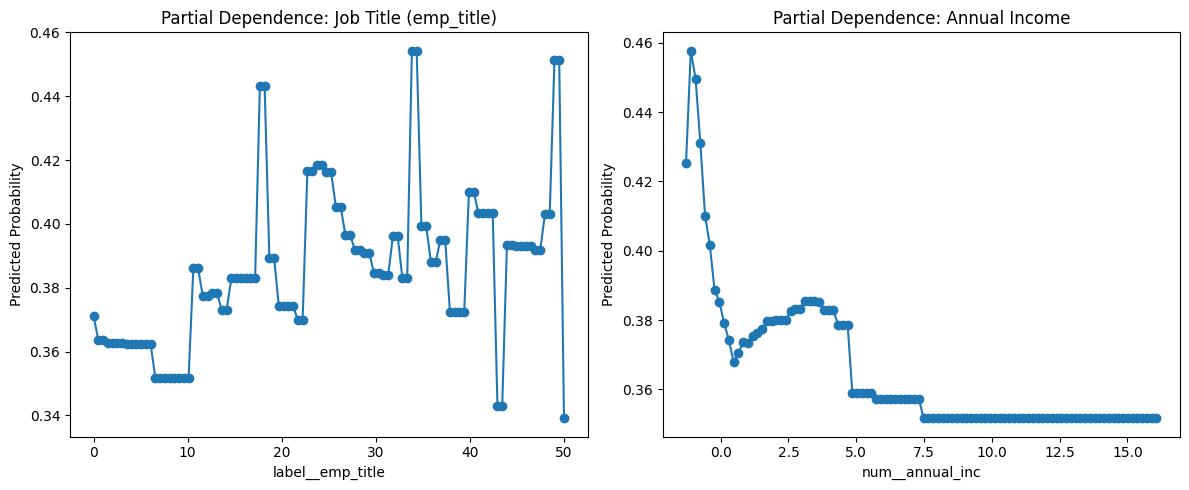

In [ ]:
# We'll compute PDP manually
def partial_dependence_manual(estimator, X, feature, grid_values):
    """
    Compute partial dependence for a single feature.

    estimator: trained model (must support predict or predict_proba)
    X: DataFrame or numpy array of test data
    feature: str (column name) or int (column index)
    grid_values: array-like, values of the feature to evaluate
    """
    pdp_values = []

    for val in grid_values:
        X_temp = X.copy()
        X_temp.loc[:, feature] = val   # replace feature with fixed value
        preds = estimator.predict_proba(X_temp)[:, 1]  # probability for class 1
        pdp_values.append(np.mean(preds))  # average prediction

    return pd.DataFrame({"value": grid_values, "pdp": pdp_values})


# Example for your features
pdp_emp_title = partial_dependence_manual(catboost, X_test, "label__emp_title", np.linspace(X_test["label__emp_title"].min(),
                       X_test["label__emp_title"].max(), 100))
pdp_income = partial_dependence_manual(catboost, X_test, "num__annual_inc", np.linspace(X_test["num__annual_inc"].min(),
                       X_test["num__annual_inc"].max(),
                       100)
)

print(pdp_emp_title.head())
print(pdp_income.head())

# Plot PDPs
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Job Title PDP
axes[0].plot(pdp_emp_title["value"], pdp_emp_title["pdp"], marker="o")
axes[0].set_title("Partial Dependence: Job Title (emp_title)")
axes[0].set_xlabel("label__emp_title")
axes[0].set_ylabel("Predicted Probability")

# Annual Income PDP
axes[1].plot(pdp_income["value"], pdp_income["pdp"], marker="o")
axes[1].set_title("Partial Dependence: Annual Income")
axes[1].set_xlabel("num__annual_inc")
axes[1].set_ylabel("Predicted Probability")

plt.tight_layout()
plt.show()

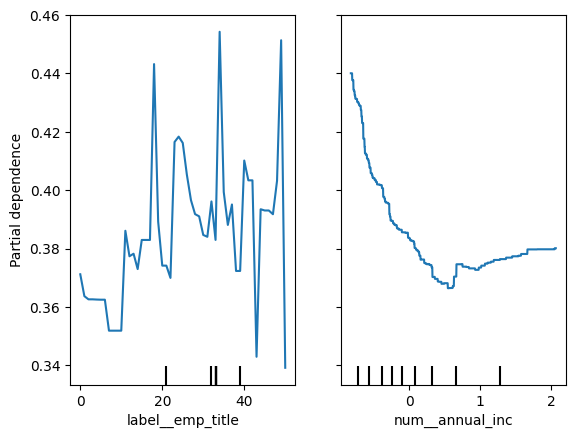

In [ ]:
# Using built in function

PartialDependenceDisplay.from_estimator(
    estimator=catboost,
    X=X_test,
    features=["label__emp_title", "num__annual_inc"],
    grid_resolution = 1000
)


There are many peaks in the jobt tile plot. This suggests the model is capturing specific effects of specific job titles (e.g., "Teacher" vs. "Self-employed" vs. "Unemployed"). However, the instability in the curve means the model might be overfitting — relying too heavily on job title, which may not generalize well.

As for the income, the more it increases (from 0 to ~1 on the scale), predicted default probability decreases steeply.
Higher income borrowers are less likely to default.
After around 1 (mid-to-high income), the curve flattens and even slightly increases. This suggests a diminishing return effect: once income is above a certain level, extra income does not reduce default risk much further.
Income is a strong protective factor against default up to a threshold. Beyond that threshold, its effect weakens.

One can argue that if a model is “fair,” job title should not add much beyond income. This may mean a bias towards more fancy titles. In principle, the risk of default should depend on ability and willingness to repay (income, debt ratio, credit history), not the prestige of the job title. Since income is already in the model and strongly correlated with job title, any additional “signal” from job title may actually reflect social bias. Job title could act as a proxy variable for protected characteristics (like education, social class, even indirectly race or gender). If the model is fair, then after controlling for income (and maybe employment stability), job title should not add much predictive power.
If it does add, it might mean the model is learning additional associations — rewarding certain professions. This entails the risk that the bank favors some jobs because they “look better on paper,” rather than because they affect repayment.

However let's keep in mind that label encoding gives job titles arbitrary numeric values, so the PDP treats them as if there’s an “order”, which may produce misleading results.